# PI7 Assignment 

## Deel 1
In dit notebook voer ik de vereiste stappen uit van de PI7-opdracht.  
Ik analyseer de SQL-database, extraheer de data naar Python, voer een uitgebreide Exploratory Data Analysis (EDA) uit en onderzoek de datakwaliteit.  
Daarnaast beschrijf ik de noodzakelijke voorbereidingen voor verdere machine-learning analyse en realiseer ik de volledige datacleaning-pipeline.

# Overzicht van de Database

Deze database bestaat uit twee tabellen die met elkaar verbonden zijn via een foreign key.

## Tabellen en Relaties

De hoofdtabellen zijn:

- **race_results**
- **riders**

De relatie tussen beide tabellen loopt via **rider_id**, welke fungeert als primary key in `riders` en als foreign key in `race_results`.


## Kolommen per Tabel

![image info](./images/ERD.png)

In [ ]:
import sqlite3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pad naar database
db_path = os.path.join("data", "cycling_db.db")
conn = sqlite3.connect(db_path)

# Lees tabellen in als DataFrame
df_rider = pd.read_sql_query("SELECT * FROM riders;", conn)
df_race_results = pd.read_sql_query("SELECT * FROM race_results;", conn)

conn.close()
df_rider.head()

,id,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Stage_Type,Start,Finish,Race_ID,Stage_Number,Length,Category,Race_url,Stage_url,rider_id
0,1,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,659ed585810c65fe22255a5e4a9b7838
1,2,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None
2,3,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None
3,4,4,8.0,+0:10,0,SABATINI Fabio,26,Liquigas - Cannondale,1.0,13.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,13ed0fc8c2b0dcd2c4e1ac48b88166b8
4,5,5,9.0,+0:10,0,BENNATI Daniele,31,RadioShack - Nissan,1.0,10.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,c0c77a7b1a8b55d9641962ba21981cab


In [ ]:
df_race_results.head()

## Grootte van de Dataset

- **Aantal rijen:** 
  - `race_results`: 225918 
  - `riders`: 1042 


- **Aantal kolommen:**  
  - `race_results`: 25  
  - `riders`: 10

In [2]:
df_race_results.info()
df_race_results.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225918 entries, 0 to 225917
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            225918 non-null  int64  
 1   Rnk           225918 non-null  object 
 2   GC            195498 non-null  float64
 3   Timelag       195498 non-null  object 
 4   BiB           225918 non-null  object 
 5   Rider         225918 non-null  object 
 6   Age           225918 non-null  int64  
 7   Team          225889 non-null  object 
 8   UCI           11844 non-null   float64
 9   Pnt           31760 non-null   float64
 10  Time          225918 non-null  object 
 11  Circuit       225918 non-null  int64  
 12  Race_Name     225918 non-null  object 
 13  Stage_Name    200677 non-null  object 
 14  Date          225918 non-null  object 
 15  Stage_Type    225918 non-null  object 
 16  Start         225918 non-null  object 
 17  Finish        225918 non-null  object 
 18  Race

id                   0
Rnk                  0
GC               30420
Timelag          30420
BiB                  0
Rider                0
Age                  0
Team                29
UCI             214074
Pnt             194158
Time                 0
Circuit              0
Race_Name            0
Stage_Name       25241
Date                 0
Stage_Type           0
Start                0
Finish               0
Race_ID              0
Stage_Number         0
Length               0
Category             0
Race_url             0
Stage_url        25241
rider_id         52189
dtype: int64

count    225918.000000
mean         28.298936
std           4.270149
min          18.000000
25%          25.000000
50%          28.000000
75%          31.000000
max          45.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'Age distribution of riders')

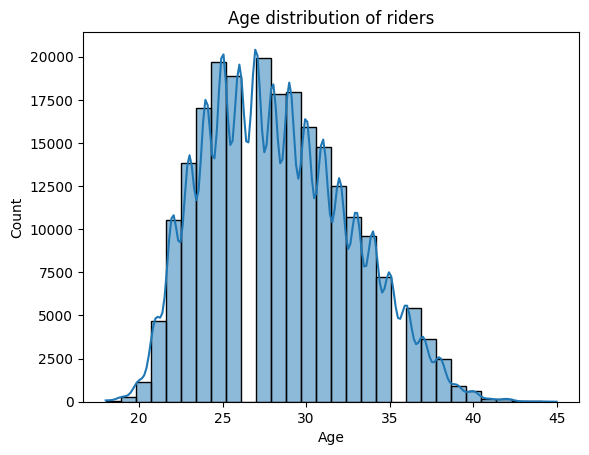

In [3]:
print(df_race_results["Age"].describe())
sns.histplot(data=df_race_results, x="Age", bins=30, kde=True)
plt.title("Age distribution of riders")


De kolom Rnk bleek zowel numerieke rankings als speciale statuscodes te bevatten. Waarden zoals DNF, DNS, OTL en DSQ representeren renners die niet gefinisht zijn. Daarnaast worden sommige statuscodes numeriek gecodeerd, zoals 990, 1000, 1005, 1006 en 1007. Deze waarden vertegenwoordigen geen geldige wedstrijdresultaten en zijn daarom verwijderd.

Vervolgens zijn alle overblijvende rankingwaarden opgeschoond door whitespace te verwijderen en om te zetten naar numeriek. Enkel renners met een geldige finishpositie (Rnk < 990) zijn behouden voor verdere analyses.

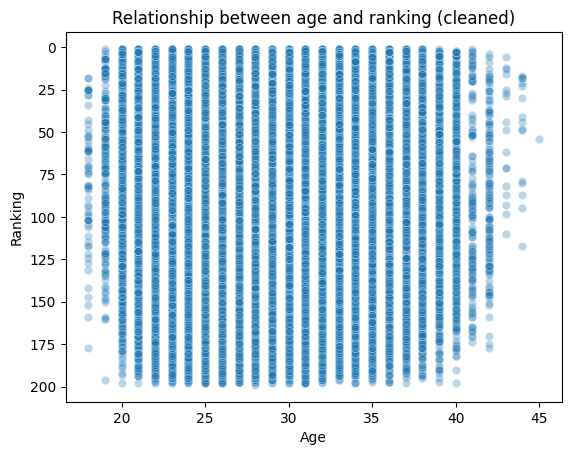

In [4]:
df_race_results["Rnk_clean"] = (
    df_race_results["Rnk"]
    .astype(str)
    .str.replace("\xa0", "", regex=False)
    .str.strip()
)

invalid_text = ["DNF", "DNS", "OTL", "DSQ"]
df_race_results.loc[
    df_race_results["Rnk_clean"].isin(invalid_text),
    "Rnk_clean"
] = None

df_race_results["Rnk_num"] = pd.to_numeric(df_race_results["Rnk_clean"], errors="coerce")

df_clean = df_race_results[df_race_results["Rnk_num"] < 990]

sns.scatterplot(data=df_clean, x="Age", y="Rnk_num", alpha=0.3)
plt.gca().invert_yaxis()  # Rank 1 bovenaan
plt.title("Relationship between age and ranking (cleaned)")
plt.xlabel("Age")
plt.ylabel("Ranking")
plt.show()

Text(0.5, 1.0, 'Missing value map')

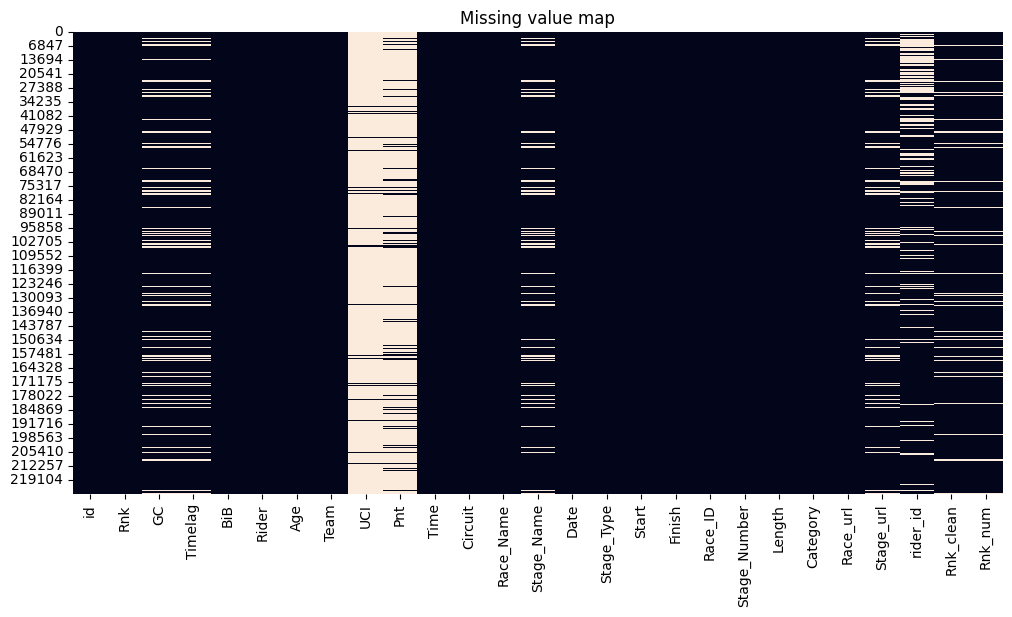

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df_race_results.isna(), cbar=False)
plt.title("Missing value map")


In [6]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rider_id   1042 non-null   object 
 1   fullname   1042 non-null   object 
 2   team       1042 non-null   object 
 3   birthdate  1042 non-null   object 
 4   country    1042 non-null   object 
 5   height     1042 non-null   float64
 6   weight     1042 non-null   float64
 7   rider_url  1042 non-null   object 
 8   pps        1042 non-null   object 
 9   rdr        1042 non-null   object 
dtypes: float64(2), object(8)
memory usage: 81.5+ KB


Text(0.5, 1.0, 'Missing value map')

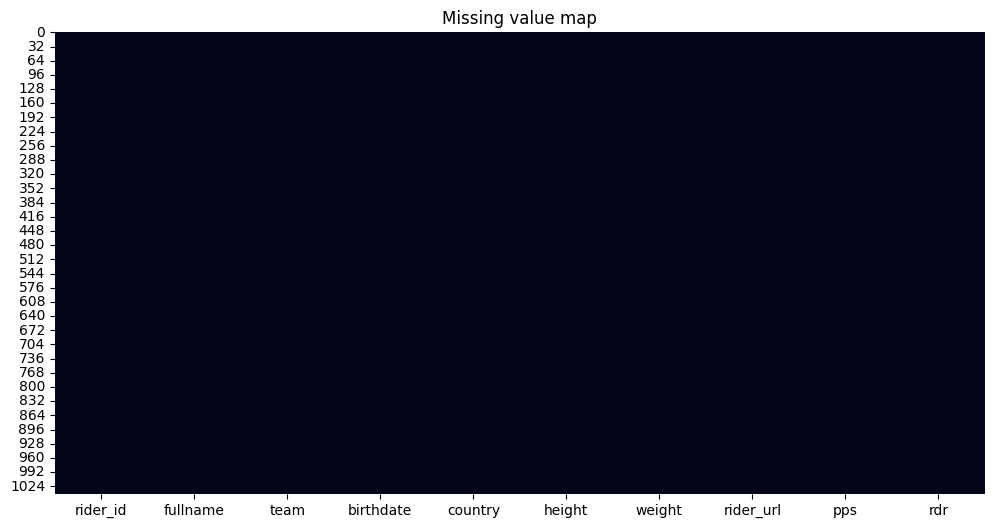

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df_rider.isna(), cbar=False)
plt.title("Missing value map")